
# Covid-19-Infection-Percentage-Estimation-Challenge

This is a competetion organized at [codalab](https://competitions.codalab.org/competitions/35575#learn_the_details-evaluation). The problem is to find percentage of infection caused by COVID in Chest CT scan. This problem is different from classification where we figure out whether the person is infected by COVID or not. In this competetion we have found out the percentage of infection caused. 

## dataset information
The challenge has three sets: Train, Val, and Test. The Train set is obtained from 132 CT-scans, from which 128 CT-scans has confirmed to have Covid-19 based on positive reverse transcription polymerase chain reaction (RT-PCR) and CT scan manifestations identified by two experienced thoracic radiologists. The rest four CT-scans have not any infection type (Healthy). The Val set is obtained from 57 CT-scans, from which 55 CT-scans has confirmed to have Covid-19 based on positive reverse transcription polymerase chain reaction (RT-PCR) and CT scan manifestations identified by two experienced thoracic radiologists. The rest two CT-scans have not any infection type (Healthy).

The evaluation cirtieria for the competetion is **mean absolute error (mae)**. The two thing that we are not classifying the disease and healthy images and evaluation metric is not accuracy/f1score make us think that this is not the classification problem. There for we have decided to take it as regression problem becuase mae is usually considered in regerssion problem.

Dataset is available at [github](https://github.com/faresbougourzi/Covid-19-Infection-Percentage-Estimation-Challenge) and we have downloaded it. 

## Our approach
We need following things
* a deep learning model
* a loss function
* 5 fold cross validation approach
* an optimizer
* few augmentation function

There are 2 folders in dataset train and validation and one csv file which is train.csv. We have created another folder to save our code

# import libraries

In [1]:
import cv2
import os
import numpy as np 
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,GroupKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as PL
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import  ReduceLROnPlateau,CosineAnnealingWarmRestarts,CosineAnnealingLR
from pytorch_lightning import seed_everything, LightningModule, Trainer

2021-12-18 15:46:21.794998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
!python -V

Python 3.8.10


In [3]:
print('pytorch version',torch.__version__)
print('pytorch_lightning version',PL.__version__)
print('albumentation version',A.__version__)
print('gpu device',torch.cuda.get_device_name(0))
print('cuda version',torch.version.cuda)
print('cudnn version',torch.backends.cudnn.version())

pytorch version 1.7.1+cu110
pytorch_lightning version 1.5.4
albumentation version 1.1.0
gpu device NVIDIA GeForce RTX 3070 Ti
cuda version 11.0
cudnn version 8005


# Read train.csv file
at the time of making this tutorial, we dont have have test images, nor we have ground truth of val data. So, i will use val data as test data. 
further we have only one csv file which is train.csv file, so we have to generate a csv file/dataframe for validation ourself


In [4]:
path='../regression/'#path where all data is present

In [5]:
df=pd.read_csv(os.path.join(path,'Train.csv'),header=None)
df.columns=['image','label','subject']
df.image=path+'Train/'+df.image
df.head()
#now we have path to all images and corresponding labels . we can ingore subkect column

,image,label,subject
0,../regression/Train/Image_0000.png,0.0,0
1,../regression/Train/Image_0001.png,0.0,0
2,../regression/Train/Image_0002.png,0.0,0
3,../regression/Train/Image_0003.png,0.0,0
4,../regression/Train/Image_0004.png,0.0,0


In [6]:
# creating a dataframe for validation images
test_path=sorted(glob(os.path.join(path,'Val','*.png'))) #get path of all images in validation set and sort them
test_split=pd.DataFrame(test_path,columns=['image']) #convert them to dataframe
images_name=[i.split('/')[-1] for i in test_path] #get the image name, so we can create a submission file
print(test_split)

                                 image
0     ../regression/Val/Image_0000.png
1     ../regression/Val/Image_0001.png
2     ../regression/Val/Image_0002.png
3     ../regression/Val/Image_0003.png
4     ../regression/Val/Image_0004.png
...                                ...
1296  ../regression/Val/Image_1296.png
1297  ../regression/Val/Image_1297.png
1298  ../regression/Val/Image_1298.png
1299  ../regression/Val/Image_1299.png
1300  ../regression/Val/Image_1300.png

[1301 rows x 1 columns]


# dataloader
we need this dataframe to load into pytorch framework, so i will write a custom dataloader.

In [7]:
class DataReader(torch.utils.data.Dataset):
    #Characterizes a dataset for PyTorch'
    def __init__(self, df,aug=False,test=False):
        'Initialization'
        self.df=df
        self.transform=aug
        self.test=test
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        file = self.df['image'][index]
        image=cv2.imread(file)
        image=np.array(image)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image=self.transform(image=image)['image']
        if self.test is False:
            label=self.df['label'][index]
            return image,label.flatten().astype('float32')
        else:
            return image

# Augmentation
here we will define all augmentation/transformation we will use

In [8]:
def augmentation(img_size=224):
    aug= A.Compose([
                A.Resize(img_size+32,img_size+32),
                A.CenterCrop(img_size,img_size),
                A.HorizontalFlip(0.5),
                A.ShiftScaleRotate(rotate_limit=10),
                A.Normalize(),
                ToTensorV2(p=1.0),
            ], p=1.0)
    return aug
aug=augmentation()

# check every thing working till here

In [9]:
sample_reader=DataReader(df,aug);    
sample_loader = DataLoader(sample_reader,shuffle=True,num_workers=0,batch_size=4,)
batch=next(iter(sample_loader));
print(batch[0].shape,batch[1].shape)

torch.Size([4, 3, 224, 224]) torch.Size([4, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


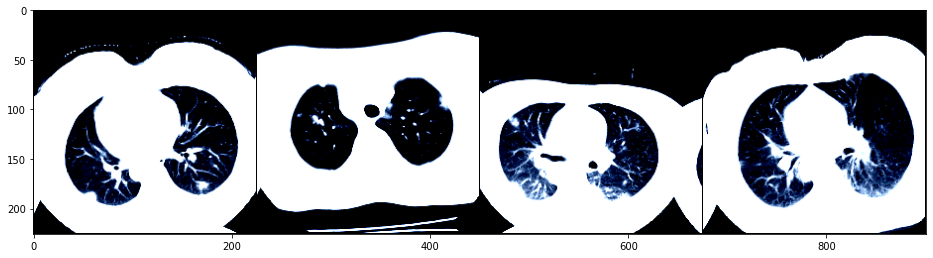

In [10]:
plt.figure(figsize=(16,16))
grid_img=torchvision.utils.make_grid(batch[0],4,1)
plt.imshow(grid_img.permute(1, 2, 0))

# pytorch lightning framework

In [24]:
import timm
import torchmetrics
import torchvision.models as models
class OurModel(LightningModule):
    def __init__(self,train_split,val_split,fold):
        super(OurModel,self).__init__()
        
        self.train_split=train_split
        self.val_split=val_split
        self.fold=fold
        
        self.model =  timm.create_model('resnest50d',pretrained=True)
           
        self.fc1=nn.Linear(1000,500)
        self.relu=nn.ReLU()
        self.fc2= nn.Linear(500,250)
        self.fc3= nn.Linear(250,1)
        
        #parameters
        self.lr=1e-3
        self.batch_size=72
        self.numworker=8
        self.criterion=nn.L1Loss()
        self.trainloss,self.valloss=[],[]
        self.preds=0
        
    def forward(self,x):
        x= self.model(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        return x

    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        scheduler=CosineAnnealingLR(opt,T_max=10,  eta_min=1e-6, last_epoch=-1)
        return {'optimizer': opt,'lr_scheduler':scheduler}

        
    def train_dataloader(self):
        return DataLoader(DataReader(self.train_split,aug), batch_size = self.batch_size, 
                          num_workers=self.numworker,pin_memory=True,shuffle=True)

    def training_step(self,batch,batch_idx):
        image,label=batch
        out = self(image)
        loss=self.criterion(out,label)
        return {'loss':loss}

    def training_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.trainloss.append(loss)
        self.log('train_loss', loss)
        
    def val_dataloader(self):
        ds=DataLoader(DataReader(self.val_split,aug), batch_size = self.batch_size,
                      num_workers=self.numworker,pin_memory=True, shuffle=False)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        out=self(image)
        loss=self.criterion(out,label)
        return {'loss':loss}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valloss.append(loss)
        print('validation loss ',self.current_epoch,loss)
        self.log('val_loss', loss)


    def test_dataloader(self):
        return DataLoader(DataReader(test_split,aug,True), batch_size = self.batch_size,
                          num_workers=self.numworker,pin_memory=True,shuffle=False)

    def test_step(self,batch,batch_idx):
        image=batch
        out=self(image)
        return {'pred':out}
    
    def test_epoch_end(self, outputs):
        pred=torch.cat([x["pred"] for x in outputs]).detach().cpu().numpy().ravel()
        self.preds=pred

# model training,validation and prediction with 5 fold cross validation

In [25]:
seed_everything(0)#help to get same result every time
lr_monitor = LearningRateMonitor(logging_interval='epoch')
kfold = GroupKFold(n_splits=5)
train_loss,val_loss,preds=[],[],[]
for fold,(train_idx,val_idx) in enumerate(kfold.split(df,groups=df.subject)):
    print('------------fold no---------{}----------------------'.format(fold))
    train_split=df.loc[train_idx].reset_index(drop=True)
    val_split=df.loc[val_idx].reset_index(drop=True)

    model=OurModel(train_split,val_split,fold)

    trainer = Trainer(max_epochs=1, 
                    deterministic=True,
                    gpus=-1,precision=16,
                    accumulate_grad_batches=2,
                    enable_progress_bar = False,
                    log_every_n_steps=10,
                    num_sanity_val_steps=0,
                    callbacks=[lr_monitor],
                    #resume_from_checkpoint=path+'code/checkpoints/lambdalast.ckpt',
                    )




    trainer.fit(model)
    #model.load_state_dict(torch.load(os.path.join(path,'code','models','model_{}.pth'.format(fold))))
    train_loss.append(model.trainloss)
    val_loss.append(model.valloss)
    
    res=trainer.validate(model)
    val_score.append(res[0]['val_loss'])
    
    trainer.test(model)
    torch.save(model.state_dict(), os.path.join(path,'models_weights','model_{}.pth'.format(fold)))
    preds.append(model.preds)

Global seed set to 0


------------fold no---------0----------------------


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type   | Params
-------------------------------------
0 | model     | ResNet | 27.5 M
1 | fc1       | Linear | 500 K 
2 | relu      | ReLU   | 0     
3 | fc2       | Linear | 125 K 
4 | fc3       | Linear | 251   
5 | criterion | L1Loss | 0     
-------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
56.218    Total estimated model params size (MB)


validation loss  0 16.36


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


validation loss  0 16.01
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 16.010000228881836}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
------------fold no---------1----------------------


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type   | Params
-------------------------------------
0 | model     | ResNet | 27.5 M
1 | fc1       | Linear | 500 K 
2 | relu      | ReLU   | 0     
3 | fc2       | Linear | 125 K 
4 | fc3       | Linear | 251   
5 | criterion | L1Loss | 0     
-------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
56.218    Total estimated model params size (MB)


validation loss  0 14.79


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


validation loss  0 14.78
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 14.779999732971191}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
------------fold no---------2----------------------


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type   | Params
-------------------------------------
0 | model     | ResNet | 27.5 M
1 | fc1       | Linear | 500 K 
2 | relu      | ReLU   | 0     
3 | fc2       | Linear | 125 K 
4 | fc3       | Linear | 251   
5 | criterion | L1Loss | 0     
-------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
56.218    Total estimated model params size (MB)


validation loss  0 19.97


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


validation loss  0 19.66
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 19.65999984741211}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
------------fold no---------3----------------------


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type   | Params
-------------------------------------
0 | model     | ResNet | 27.5 M
1 | fc1       | Linear | 500 K 
2 | relu      | ReLU   | 0     
3 | fc2       | Linear | 125 K 
4 | fc3       | Linear | 251   
5 | criterion | L1Loss | 0     
-------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
56.218    Total estimated model params size (MB)


validation loss  0 12.64


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


validation loss  0 10.93
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 10.930000305175781}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
------------fold no---------4----------------------


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type   | Params
-------------------------------------
0 | model     | ResNet | 27.5 M
1 | fc1       | Linear | 500 K 
2 | relu      | ReLU   | 0     
3 | fc2       | Linear | 125 K 
4 | fc3       | Linear | 251   
5 | criterion | L1Loss | 0     
-------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
56.218    Total estimated model params size (MB)


validation loss  0 49.29


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


validation loss  0 49.88
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 49.880001068115234}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [26]:
avg=np.mean(val_score)
print('average val score is',avg)

average val score is 21.21166690190633


# plot the graph

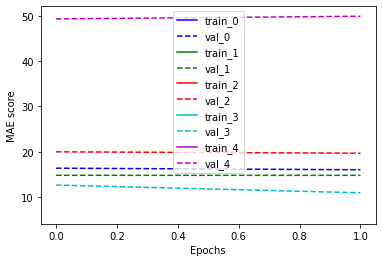

In [27]:
colors_list=['b','g','r','c','m']
plt.figure()
for i in range(5):
    plt.plot(train_loss[i],label='train_{}'.format(i),color=colors_list[i],linestyle='-')
    plt.plot(val_loss[i],label='val_{}'.format(i),color=colors_list[i],linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('MAE score')
plt.legend()
plt.savefig('graph_calr.png')

# ensemble the model

In [28]:
preds[0].shape

(1301,)

In [30]:
mean=np.mean(preds,0)
mean.shape

(1301,)

In [34]:
submission=pd.DataFrame(zip(images_name,mean))
submission.head()

,0,1
0,Image_0000.png,1.150391
1,Image_0001.png,1.318359
2,Image_0002.png,1.115234
3,Image_0003.png,0.837402
4,Image_0004.png,13.656250


In [36]:
submission.to_csv('predictions.csv',index=False,header=None)

# final thoughts

Now you can submit this file to the competetion at [codalab](https://competitions.codalab.org/competitions/35575). 
The current top score is show in image. With the above approach you can get a descent ranking as we achived a average cross validation score as calculated above.
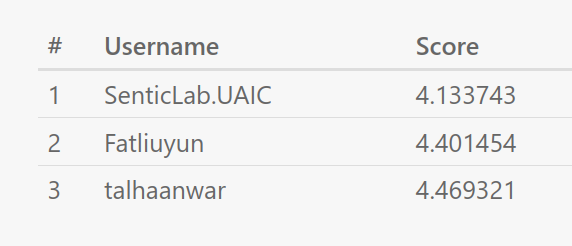
